#**Forecasting Stock Movements: A Journey through Data Exploration and Machine Learning**  
Name : 312707003黃鈺婷  
Created on 2023/10/13  
Updated on 2023/12/22


##**Motivation**

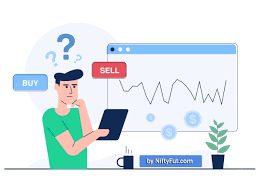

I have done simulated trading of futures and options before, but it's not easy  to accurately grasp the timing of buying and selling.  
As a result, I hope to use machine learning to predict whether a stock will rise or fall five days from now, so that I can grasp the buying and selling signals.

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2024-01-05 08:19:18--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-05 08:19:19--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-05 08:19:19--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
from talib import abstract
import matplotlib.pyplot as plt
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns
from sklearn.metrics import f1_score

##**Data**

###(1). 抓取台股資料(Yahoo Finance API)

In [3]:
date = '2018-01-01'
end = '2023-12-10'
stock_no = '^TWII'
stock_data = yf.download(stock_no, date, end)

stock_data = stock_data.reset_index()

#更改column name，方便之後計算技術指標
stock_data.rename(columns={'Open':'open'}, inplace=True)
stock_data.rename(columns={'High':'high'}, inplace=True)
stock_data.rename(columns={'Low':'low'}, inplace=True)
stock_data.rename(columns={'Close':'close'}, inplace=True)
stock_data.rename(columns={'Adj Close':'adj close'}, inplace=True)
stock_data.rename(columns={'Volume':'volume'}, inplace=True)

stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,open,high,low,close,adj close,volume
0,2018-01-02,10664.820312,10710.730469,10650.769531,10710.730469,10710.730469,2375900
1,2018-01-03,10759.610352,10813.160156,10759.610352,10801.570312,10801.570312,2964800
2,2018-01-04,10834.580078,10853.459961,10794.250000,10848.629883,10848.629883,3048500
3,2018-01-05,10856.919922,10879.799805,10815.679688,10879.799805,10879.799805,3028400
4,2018-01-08,10899.089844,10918.469727,10869.120117,10915.750000,10915.750000,3246900


###(2). 計算技術指標(使用TA-Lib)


####(a). 移動平均線

In [4]:
stock_data['5_MA'] = abstract.SMA(stock_data, 5)  #計算5日移動平均線
stock_data['10_MA'] = abstract.SMA(stock_data, 10) #計算10日移動平均線

####(b). RSI

In [5]:
stock_data['rsi'] = abstract.RSI(stock_data, 14)


####(c). KD值

In [6]:
stock_data['k'] = abstract.STOCH(stock_data, fastk_period=9, slowk_period=3, slowd_period=3)['slowk']
stock_data['d'] = abstract.STOCH(stock_data, fastk_period=9, slowk_period=3, slowd_period=3)['slowd']


####(d). MACD

In [7]:
stock_data["macd"] = abstract.MACD(stock_data, fastperiod=12, slowperiod=26, signalperiod=9)["macd"]
stock_data["macdsignal"] = abstract.MACD(stock_data, fastperiod=12, slowperiod=26, signalperiod=9)["macdsignal"]
stock_data["macdhist"] = abstract.MACD(stock_data, fastperiod=12, slowperiod=26, signalperiod=9)["macdhist"]


###(3). 計算5交易日後的漲跌

In [8]:
stock_data['I5'] = np.where(stock_data.close.shift(-1) > stock_data.close, 1, 0)
stock_data.tail()


,Date,open,high,low,close,adj close,volume,5_MA,10_MA,rsi,k,d,macd,macdsignal,macdhist,I5
1439,2023-12-04,17450.640625,17516.609375,17398.099609,17421.480469,17421.480469,3929200,17401.098047,17345.183984,67.625412,89.617013,87.737255,223.087449,211.380919,11.706530,0
1440,2023-12-05,17401.589844,17401.589844,17252.570312,17328.009766,17328.009766,3623500,17398.450000,17336.315039,62.203695,74.055492,84.621356,210.505546,211.205845,-0.700298,1
1441,2023-12-06,17340.820312,17439.849609,17337.470703,17360.720703,17360.720703,3307100,17396.482031,17341.361133,63.312232,61.724119,75.132208,200.858426,209.136361,-8.277935,0
1442,2023-12-07,17356.919922,17387.939453,17273.710938,17278.740234,17278.740234,3368200,17365.460156,17339.780078,58.668095,49.296242,61.691951,184.471403,204.203369,-19.731966,1
1443,2023-12-08,17309.359375,17465.349609,17309.359375,17383.990234,17383.990234,3155300,17354.588281,17349.437109,62.473906,53.814621,54.944994,177.926341,198.947963,-21.021623,0


##**EDA**##

###(1).Summary statistic

In [9]:
variable_descriptions = stock_data.describe()
print(variable_descriptions)

               open          high           low         close     adj close  \
count   1444.000000   1444.000000   1444.000000   1444.000000   1444.000000   
mean   13694.650606  13761.452448  13621.213626  13692.807162  13692.807162   
std     2811.173784   2826.445275   2794.046862   2810.452079   2810.452079   
min     8816.860352   9029.519531   8523.629883   8681.339844   8681.339844   
25%    10909.425293  10949.367432  10865.052734  10903.695312  10903.695312   
50%    13428.775391  13573.180176  13428.775391  13519.009766  13519.009766   
75%    16501.259766  16583.208008  16418.759277  16500.437988  16500.437988   
max    18598.130859  18619.609375  18446.519531  18526.349609  18526.349609   

             volume          5_MA         10_MA          rsi            k  \
count  1.444000e+03   1440.000000   1435.000000  1430.000000  1432.000000   
mean   3.421463e+06  13691.780748  13690.275105    53.842229    58.927435   
std    1.724396e+06   2805.874384   2800.552789    12.743

###(2).Pairwise plot

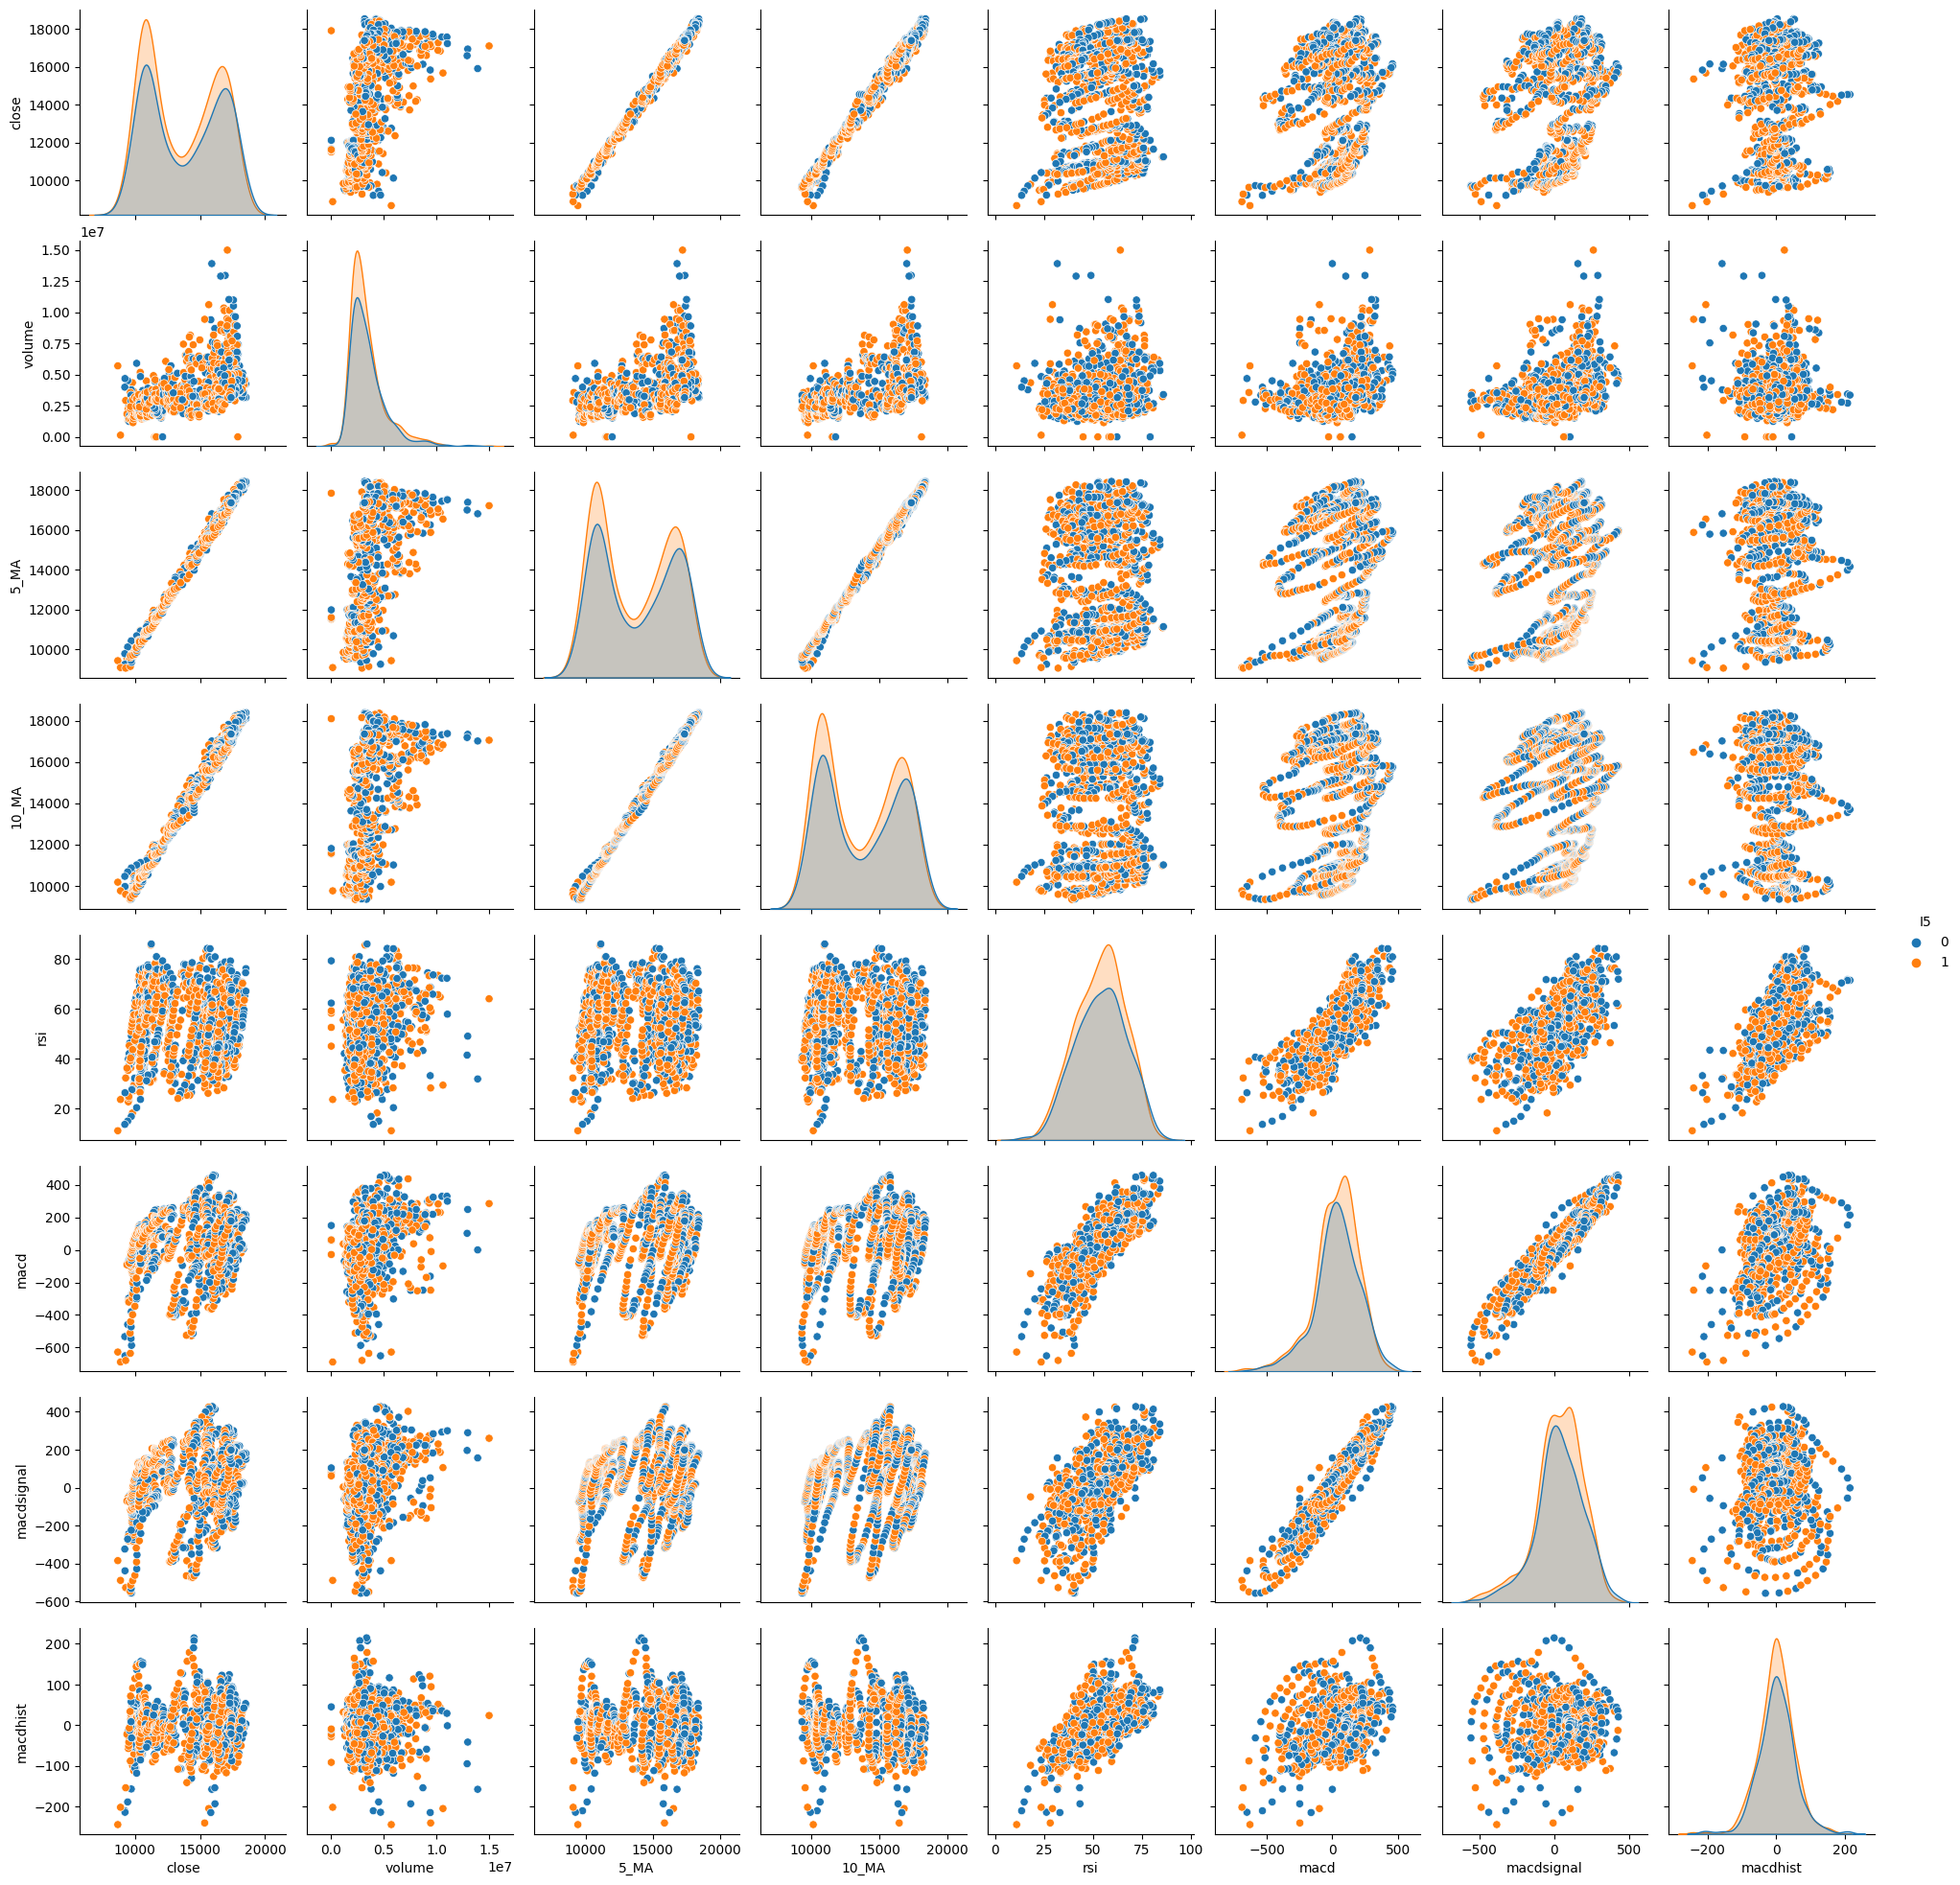

In [10]:
selected_variables = stock_data[['close', 'volume', '5_MA', '10_MA', 'rsi', 'macd', 'macdsignal', 'macdhist', 'I5']]
# 使用pairplot
sns.pairplot(selected_variables, hue='I5') #hue='I5'以根據'I5'列點進行着色
plt.show()

###(3).Boxplot

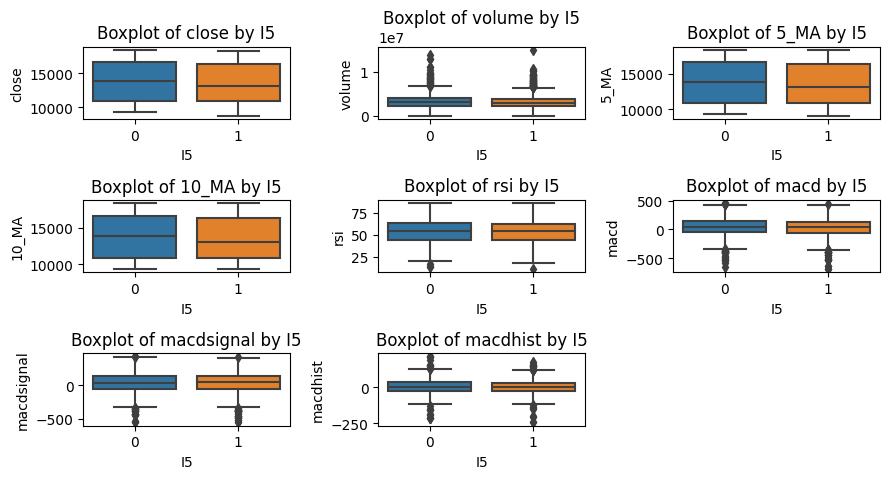

In [11]:
selected_variables = ['close', 'volume', '5_MA', '10_MA', 'rsi', 'macd', 'macdsignal', 'macdhist']

# 創建一個子圖
plt.figure(figsize=(9, 6))

# 迭代選擇的變數
for i, var in enumerate(selected_variables, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=stock_data['I5'], y=stock_data[var])
    plt.title(f'Boxplot of {var} by I5')

# 調整子圖佈局
plt.tight_layout()

# 顯示圖形
plt.show()


###(4). Correlation matrix

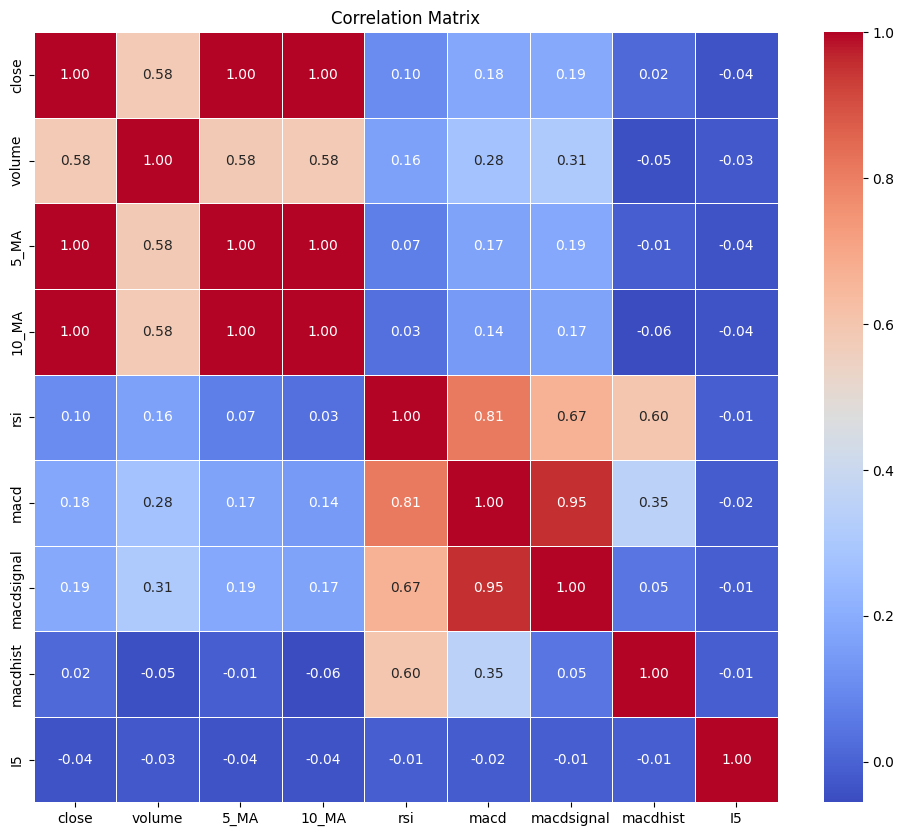

In [12]:
selected_variables = ['close', 'volume', '5_MA', '10_MA', 'rsi', 'macd', 'macdsignal', 'macdhist', 'I5']

# 選擇相關性分析的變數
correlation_data = stock_data[selected_variables]

# 計算相關性矩陣
correlation_matrix = correlation_data.corr()

# 使用 seaborn 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

###(5). Volume & Close price

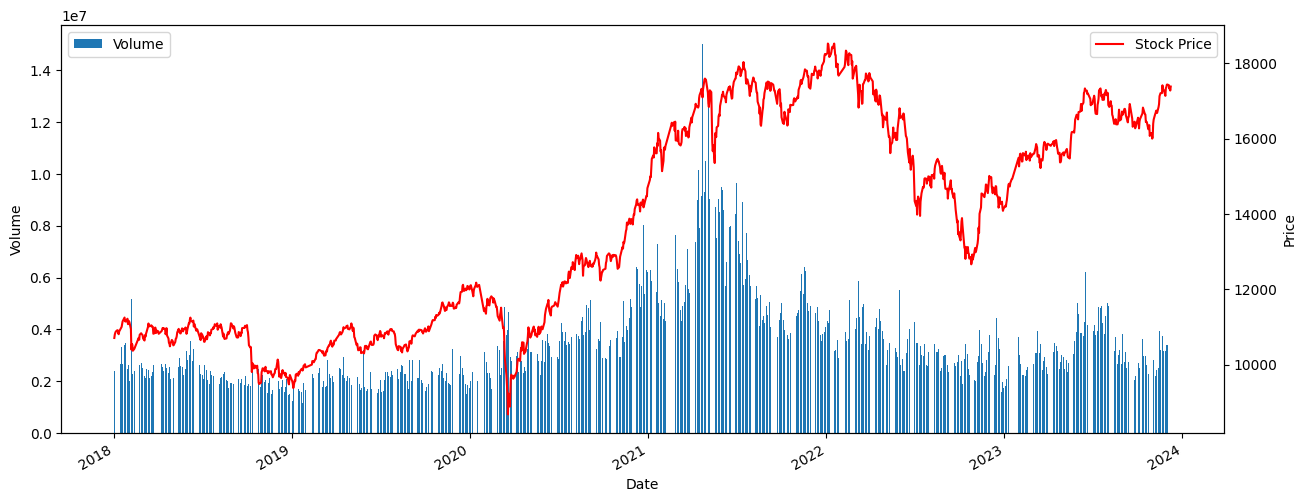

In [13]:
fig, ax1 = plt.subplots(figsize=(15, 6))

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# 排序 DataFrame 按照日期
data = stock_data.sort_values('Date')

# 繪製每日交易量的長條圖
ax1.bar(data['Date'], data['volume'], label = "Volume")

# 添加標題和標籤
plt.xlabel('Date')
plt.ylabel('Volume')

ax2 = ax1.twinx()

# 繪製每日股價的折線圖
ax2.plot(data['Date'], data['close'], color='r', label='Stock Price')

# 添加第二個 Y 軸標籤
ax2.set_ylabel('Price')

# 顯示圖例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 自動格式化 x 軸上的日期
plt.gcf().autofmt_xdate()

# 顯示圖形
plt.show()


###(6). The trend of stock price

<ipython-input-14-a50a4e24a6ce>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot_date(t, y, 'b-', color = 'black')


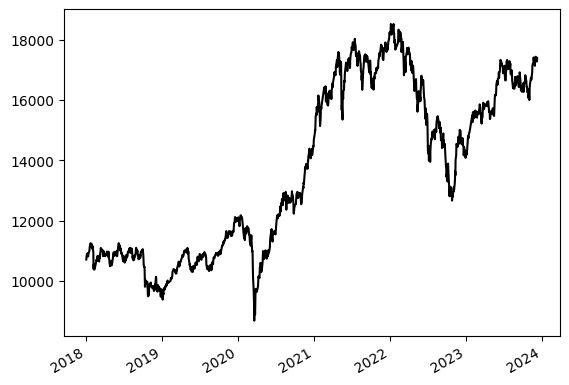

In [14]:
fig, ax = plt.subplots()
t = mdates.date2num(stock_data.Date)
y = np.array(stock_data.close)
ax.plot_date(t, y, 'b-', color = 'black')
fig.autofmt_xdate()


##**Decision tree**

In [15]:
stock_data['GoldenCross'] = stock_data['5_MA'] > stock_data['10_MA']
stock_data['RSI_Overbought'] = stock_data['rsi'] > 70
stock_data['RSI_Oversold'] = stock_data['rsi'] < 30
stock_data['KD_Overbought'] = stock_data['k'] > 80
stock_data['KD_Oversold'] = stock_data['k'] < 20
stock_data['MACD_Crossover'] = (stock_data['macd'] > stock_data['macdsignal']) & (stock_data['macd'] > 0)
stock_data = pd.get_dummies(stock_data, columns=['GoldenCross', 'RSI_Overbought', 'RSI_Oversold', 'KD_Overbought', 'KD_Oversold', 'MACD_Crossover'], drop_first=True)
stock_data.head()

,Date,open,high,low,close,adj close,volume,5_MA,10_MA,rsi,...,macd,macdsignal,macdhist,I5,GoldenCross_True,RSI_Overbought_True,RSI_Oversold_True,KD_Overbought_True,KD_Oversold_True,MACD_Crossover_True
0,2018-01-02,10664.820312,10710.730469,10650.769531,10710.730469,10710.730469,2375900,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
1,2018-01-03,10759.610352,10813.160156,10759.610352,10801.570312,10801.570312,2964800,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
2,2018-01-04,10834.580078,10853.459961,10794.250000,10848.629883,10848.629883,3048500,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
3,2018-01-05,10856.919922,10879.799805,10815.679688,10879.799805,10879.799805,3028400,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0,0,0,0,0,0
4,2018-01-08,10899.089844,10918.469727,10869.120117,10915.750000,10915.750000,3246900,10831.296094,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0


###Set training and testing data

In [16]:
split_point = int(len(stock_data)*0.8)

train = stock_data.iloc[35:split_point,:].copy()
test = stock_data.iloc[split_point:-5,:].copy()

In [18]:
train["adj_close_scaled"]=(train["adj close"]-train["adj close"].mean())/train["adj close"].std()
train["volume_scaled"]=(train["volume"]-train["volume"].mean())/train["volume"].std()
train_X = train.drop(['volume','adj close','Date','I5','high','low','open','close','5_MA','10_MA','rsi','k','d','macd','macdsignal','macdhist'], axis = 1)
train_y = train.I5

test["adj_close_scaled"]=(test["adj close"]-test["adj close"].mean())/test["adj close"].std()
test["volume_scaled"]=(test["volume"]-test["volume"].mean())/test["volume"].std()
test_X = test.drop(['volume','adj close','Date','I5','high','low','open','close','5_MA','10_MA','rsi','k','d','macd','macdsignal','macdhist'], axis = 1)
test_y = test.I5

###Model

In [19]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 5)

model.fit(train_X, train_y)

prediction = model.predict(test_X)

from sklearn.metrics import accuracy_score, confusion_matrix
#test
accuracy = accuracy_score(test_y, prediction)
conf_matrix = confusion_matrix(test_y, prediction)
f1 = f1_score(test_y, prediction, average='weighted')


print('test data')
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Weighted F1 Score: {f1:.4f}')

test data
Accuracy: 0.5422535211267606
Confusion Matrix:
[[ 42  78]
 [ 52 112]]
Weighted F1 Score: 0.5313


In [20]:
#train
prediction = model.predict(train_X)

accuracy = accuracy_score(train_y, prediction)
conf_matrix = confusion_matrix(train_y, prediction)
f1 = f1_score(train_y, prediction, average='weighted')

print('train data')
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Weighted F1 Score: {f1:.4f}')

train data
Accuracy: 0.5723214285714285
Confusion Matrix:
[[206 315]
 [164 435]]
Weighted F1 Score: 0.5600


##**Logistic Regression**

###Set training and testing data

In [21]:
split_point = int(len(stock_data)*0.8)

train = stock_data.iloc[35:split_point,:].copy()
test = stock_data.iloc[split_point:-5,:].copy()

In [23]:
train["adj_close_scaled"]=(train["adj close"]-train["adj close"].mean())/train["adj close"].std()
train["volume_scaled"]=(train["volume"]-train["volume"].mean())/train["volume"].std()
train_X = train.drop(['volume','adj close','Date','I5','high','low','open','close','5_MA','10_MA','rsi','k','d','macd','macdsignal','macdhist'], axis = 1)
train_y = train.I5

test["adj_close_scaled"]=(test["adj close"]-test["adj close"].mean())/test["adj close"].std()
test["volume_scaled"]=(test["volume"]-test["volume"].mean())/test["volume"].std()
test_X = test.drop(['volume','adj close','Date','I5','high','low','open','close','5_MA','10_MA','rsi','k','d','macd','macdsignal','macdhist'], axis = 1)
test_y = test.I5

###Model

In [24]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
lr = LogisticRegression()
mod = lr.fit(train_X, train_y)

from patsy import dmatrices
#y, X = dmatrices('I5 ~ close  + volume + GoldenCross_True + RSI_Overbought_True + RSI_Oversold_True	 + KD_Overbought_True + KD_Oversold_True + MACD_Crossover_True', data=train, return_type='dataframe')
y, X = dmatrices('I5 ~ volume_scaled + GoldenCross_True + RSI_Overbought_True + RSI_Oversold_True + KD_Overbought_True + KD_Oversold_True + MACD_Crossover_True + adj_close_scaled', data=train, return_type='dataframe')

logit = sm.Logit(y, X)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.686440
         Iterations 4


In [25]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                     I5   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1111
Method:                           MLE   Df Model:                            8
Date:                Fri, 05 Jan 2024   Pseudo R-squ.:                0.006197
Time:                        08:24:46   Log-Likelihood:                -768.81
converged:                       True   LL-Null:                       -773.61
Covariance Type:            nonrobust   LLR p-value:                    0.2951
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1035      0.114      0.907      0.364      -0.120       0.327
volume_scaled           0.1048      0.085      1.237      0.216      -0.061       0.271
GoldenCross_True

In [26]:
#confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_y, lr.predict(test_X)) #test
f1 = f1_score(test_y, lr.predict(test_X), average='weighted')

print('test data')
print(f'Accuracy: {lr.score(test_X,test_y)}')
print(f'Confusion Matrix:\n{conf_mat}')
print(f'Weighted F1 Score: {f1:.4f}')

test data
Accuracy: 0.5316901408450704
Confusion Matrix:
[[ 31  89]
 [ 44 120]]
Weighted F1 Score: 0.5059


In [27]:
conf_mat = confusion_matrix(train_y, lr.predict(train_X)) #train
f1 = f1_score(train_y, lr.predict(train_X), average='weighted')

print('train data')
print(f'Accuracy: {lr.score(train_X,train_y)}')
print(f'Confusion Matrix:\n{conf_mat}')
print(f'Weighted F1 Score: {f1:.4f}')

train data
Accuracy: 0.5464285714285714
Confusion Matrix:
[[136 385]
 [123 476]]
Weighted F1 Score: 0.5109
